# Time Series Analysis
---
## ARMA($p$,$q$) models

A stochastic process process $\{x_t\}$ is an ARMA($p$,$q$) process (autoregressive, moving average process of order $p$ and $q$, respectively) if we have

$$
x_t = \mu + \phi_1 x_{t-1} + \phi_2 x_{t-2} + ... \phi_p x_{t-p} + \epsilon_{t} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} +  ...  + \theta_q \epsilon_{t-q}
$$

where $\epsilon_{t}$ is white noise, i.e. $E[\epsilon_{t}]=0$ and $Var[\epsilon_{t}]=\sigma^2$, and without loss of generality, we set $\mu$=0.

If the coefficients $\phi_i \equiv 0$, then the ARMA($p$,$q$) process collapses to an MA($q$) process. 

Similarly, if $\theta_i\equiv 0$ then the ARMA($p$,$q$) process collapses to an AR($p$) process.

A slightly more general formulation also used is given by the expression

$$
\sum_{i=0}^{p} \phi_i X_{t-i} = \sum_{i=0}^{q} \theta_i \varepsilon_{t-i}
$$

Note that this formulation introduces $\phi_0,\theta_0$ terms which were implicitly defined to be 1 above. Further, the sign of the AR coefficients is flipped from the first formulation. This is frequently how statistical computing packages treat ARMA($p$,$q$) processes.


Let's simulate some ARMA($p$,$q$) processes. We will later examine both their autocorrelation functions (ACFs) and partial autocorrelation functions (PACFs).

### Data Simulation

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")

def simulate_arma(ar=None, ma=None, nsample=100,
                  burnin=0, paths=1, seed=1):
    """Simulate ARMA data.

       Assumption: White noise shocks are Gaussian with mean = 0, std = 1.

       Args:
           ar: list or None(Default) coefs for AR process, if None, then p=0.
           ma: list or None(Default), coefs for MA process, if None, then q=0.
           nsample: int, sample size, default=100.
           burnin: int, number of sample for "warming start", default=1.
           paths: int, number of time series, default=1.
           seed: int, random seed for reproduction, default=1.

       Returns:
           y: np.array, size=[nsample, paths], generated ARMA process.

    """
    if not ar:
        ar = []
    if not ma:
        ma = []
    # Seed the random number generator
    np.random.seed(seed)

    # numpy arrays are reversed for easier indexing:
    ar, ma = np.array(ar[::-1]), np.array(ma[::-1])

    # Orders (does not include zero lag)
    p, q = len(ar), len(ma)
    max_order = max(p, q)

    # Total number of sample size
    Nsim = nsample + burnin
    # "Standard" Guassian shocks: Normal(0,1)
    eps = np.random.randn(paths, Nsim)
    # Initialize t < 0 with zeros
    eps = np.concatenate((np.zeros((paths, max_order)), eps), axis=1)
    y = np.zeros((paths, Nsim + max_order))

    # Loop to construct the ARMA processes recursively.
    for tt in range(max_order, Nsim + max_order):
        y[:, tt] = np.sum(y[:, tt - p:tt] * ar, axis=1) \
                   + np.sum(eps[:, tt - q:tt] * ma, axis=1) + eps[:, tt]

    # Drop initial zeros and burnin and transpose for plotting.
    y = y[:, max_order + burnin:].T
    return y

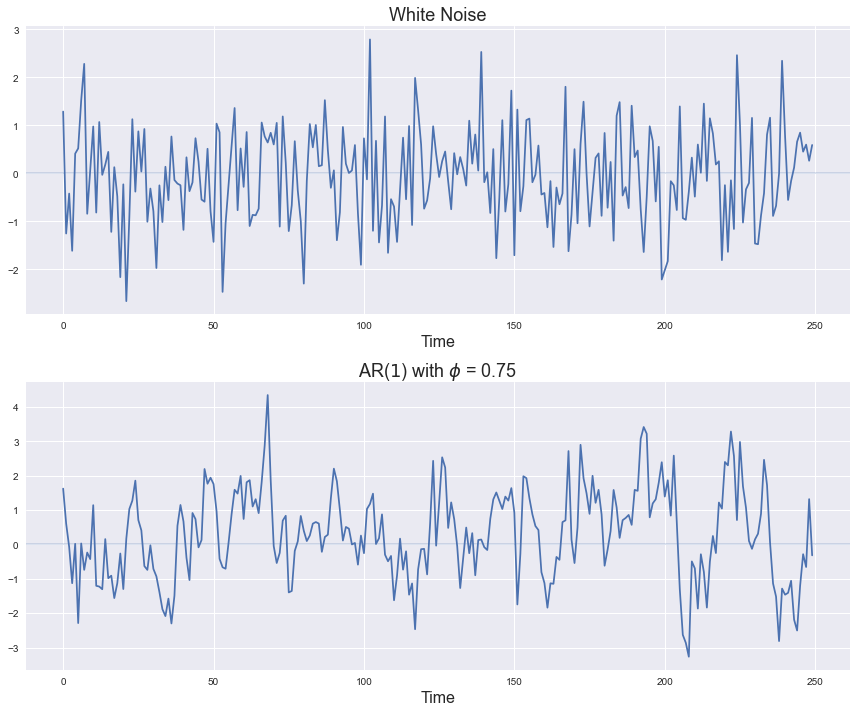

In [18]:
### Seed the random number generator
# (by default, the seed is set to 1 if no parameter is passed)
seed = np.random.seed(1)

### 1. White Noise 
y_wn = simulate_arma(nsample=250,seed=seed)

### 2. AR(1) with persistence = 0.75
phi1_model1 = 0.75
y_ar1_model1 = simulate_arma(ar=[phi1_model1], nsample=250)

fig1, axes1 = plt.subplots(nrows=2, ncols=1, figsize=(12,10))
axes1[0].plot(y_wn)
axes1[0].set_xlabel('Time', fontsize=16)
axes1[0].set_title('White Noise', fontsize=18)
axes1[0].axhline(y=0, linewidth=0.4)

axes1[1].plot(y_ar1_model1)
axes1[1].set_xlabel('Time', fontsize=16)
axes1[1].set_title('AR($1$)' + ' with $\phi$ = ' + str(phi1_model1) , fontsize=18)
axes1[1].axhline(y=0, linewidth=0.4)

fig1.tight_layout()

`statsmodels` wrapper to use

In [19]:
import statsmodels.api as sm

arparams = np.array([.75])
maparams = np.array([.65, .35])
ar = np.r_[arparams]
ma = np.r_[1]
y = sm.tsa.arma_generate_sample(ar, ma, 250)

### ACFs/PACFs

In this part, we focus on computing and understanding Autocorrelation Functions (ACFs), and Partial Autocorrelation Functions (PACFs).

The ACFs can be defined as follows:

\begin{align*}
    \text{Autocovariance function}: \gamma_j &\equiv \text{cov}(x_t,x_{t-j}) \\
    \text{Autocorrelation function}: \rho_j &\equiv \frac{\gamma_j}{\gamma_0}
\end{align*}

Both can be estimated using the Method of Moment, i.e. using their sample analogues:

\begin{align*}
    \hat{\gamma_j} &\equiv \widehat{\text{cov}}(x_t,x_{t-j}) \\
    \hat{\rho_j} &\equiv \widehat{\text{corr}}(x_t,x_{t-j})
\end{align*}

This is what we will use today. However, the ACFs can also be obtained from a regression of $x_t$ on $x_{t-j}$ (we often add a constant to the regression):

$$
    x_t = \alpha_j + \beta_j x_{t-j} + \epsilon_t
    \,\,\text{ where }\,\,
    \hat{\beta_j} = \frac{\text{cov}(x_t,x_{t-j})}{\text{var}(x_t)} = \hat{\rho_j}
$$

In a similar fashion, we can define the Partial Autocrrelation Functions (PACFs) as the correlation between $x_t$ and $x_{t-j}$ *conditional on controling for other lags* as follows (cf. Ruppert & Matteson 12.13 for details):

$$
    x_t = \beta_{0,j} + \beta_{1,j} x_{t-1} + \ldots + \beta_{j,j} x_{t-j} + \epsilon_t
    \,\,\text{ where }\,\,
    \hat{\beta_{j,j}} = \widehat{PACF_j}
$$

Below we see how to implement the estimation of ACFs and PACFs via OLS, as well as the function in statsmodels.

In [20]:
# 1. White Noise 
y_wn_long = simulate_arma(nsample=10000).squeeze()

# 2. AR(1) with persistence = 0.75
phi1_model1 = 0.75
y_ar1_model1_long = simulate_arma(ar=[phi1_model1], nsample=10000).squeeze()

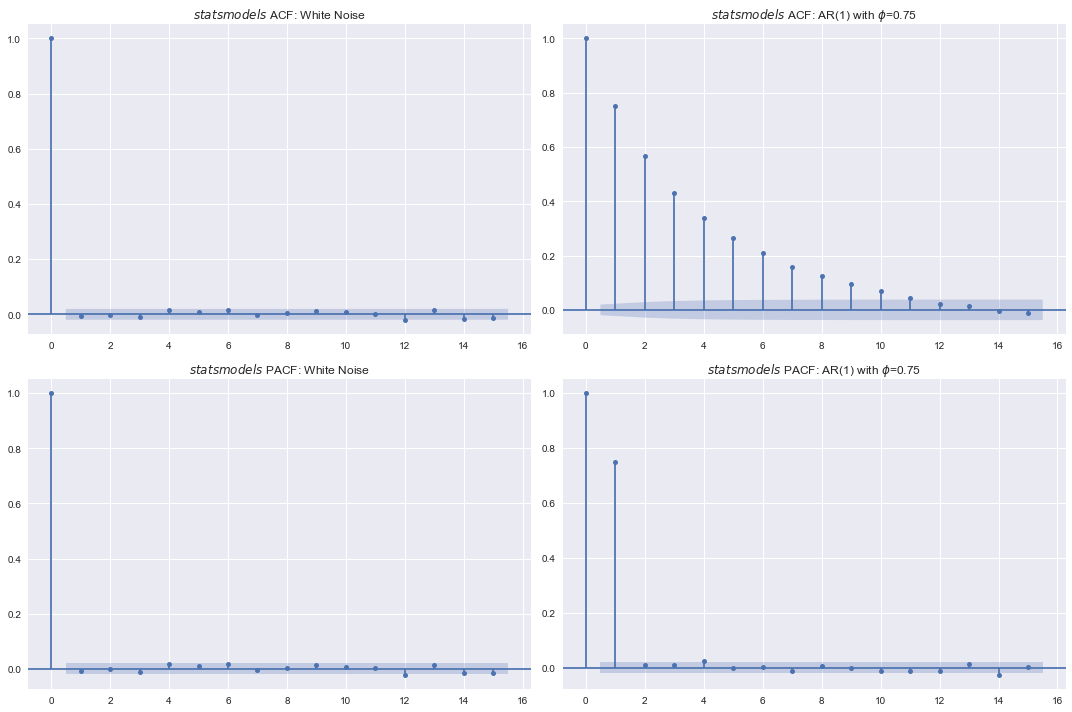

In [21]:
# statsmodels function for ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
nlags = 15
plot_acf(y_wn_long, ax=axes[0,0], lags=nlags, 
         title="${\it statsmodels}$ ACF: White Noise")
plot_pacf(y_wn_long, ax=axes[1,0], lags=nlags, 
          title="${\it statsmodels}$ PACF: White Noise")

plot_acf(y_ar1_model1_long, ax=axes[0,1], lags=nlags, 
         title="${\it statsmodels}$ ACF: AR(1) with $\\phi$=" + str(phi1_model1))
plot_pacf(y_ar1_model1_long, ax=axes[1,1], lags=nlags, 
          title="${\it statsmodels}$ PACF: AR(1) with $\\phi$=" + str(phi1_model1))

fig.tight_layout()

In [22]:
def calc_ols(y, x, addcon=True):
    """ Calculate OLS coefficients from scratch. """
    Nobs = y.shape[0]
    if addcon:
        X = np.c_[np.ones((Nobs,1)), x] # append the [Nobs x 1] columns of ones.
    else:
        X = x
    XX = np.dot(X.T, X) # Construct sample average of E[X'X]
    Xy = np.dot(X.T, y) # Construct sample average of E[X'Y]
    beta_hat = np.linalg.solve(XX, Xy) # algebraic solution for OLS. beta_hat = (E[X'X]^-1)*(E[X'Y])
    resids = y - np.dot(X, beta_hat) # residual eps_hat = y - beta_hat*X

    return beta_hat, resids, X


def lag_mat(y, nlags, fill_vals=np.nan):
    """ Create a matrix of lags of a given vector. """
    y_lags = np.empty((y.shape[0], nlags + 1))
    y_lags.fill(fill_vals)

    # Include 0 lag
    for lag in range(nlags + 1):
        y_lags[lag:, lag] = np.roll(y, shift=lag)[lag:]
    return y_lags


# ACF and PACF for a given lag
def calc_acf_lag_ols(y_lags, lag):
    """ ACF for a given lag (OLS). """
    if lag == 0:
        return 1.
    lhs = y_lags[lag:, 0]
    rhs = y_lags[lag:, lag:lag + 1]
    beta_hat, _, _ = calc_ols(y=lhs, x=rhs, addcon=True)
    return beta_hat[-1]


def calc_pacf_lag_ols(y_lags, lag):
    """ PACF for a given lag (OLS). """
    if lag == 0:
        return 1.
    lhs = y_lags[lag:, 0]
    # need y_lags[lag:, 1:lag+1] instead of y_lags[lag:,lag:lag+1] (unlike "calc_acf_lag_ols")
    rhs = y_lags[lag:, 1:lag + 1]
    beta_hat, _, _ = calc_ols(y=lhs, x=rhs, addcon=True)
    return beta_hat[-1]


# ACF and PACF for all lags
def calc_acf_ols(y, nlags):
    """ACF for multiple lags."""
    y_lags = lag_mat(y, nlags)
    acf_list = [calc_acf_lag_ols(y_lags, lag) for lag in range(nlags + 1)]
    return np.array(acf_list)


def calc_pacf_ols(y, nlags):
    """PACF for multiple lags."""
    y_lags = lag_mat(y, nlags)
    pacf_list = [calc_pacf_lag_ols(y_lags, lag) for lag in range(nlags + 1)]
    return np.array(pacf_list)


# Plotting functions
def my_plot_acf(y, nlags=10, ax=None, title_string='',
                title_fontsize=None, xlabel_string='Time'):
    """Plotting ACF with approx SEs."""
    T = y.shape[0]
    # approx SEs: scaling used in aysmptotic
    # For j = 1: 1/sqrt(T) (i.e. H0: WN)
    # For j > 1: sqrt((1 + 2*sum_{i=1}^{j-1} rho_i^2)/T)
    # For details: cf. slide 23 of Lecture 1 and part on bartlett_confin on
    # https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html
    # Note: still slightly off compared to statsmodel, so to double-check
    # se_approx = 1/np.sqrt(T)
    se_approx = np.sqrt((np.insert(1 + 2 * np.cumsum(calc_acf_ols(y, nlags) ** 2), 0, 1, axis=0)[:-1]) / T)
    # set up figure
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    # ACF
    ax.plot(calc_acf_ols(y, nlags), c='xkcd:true blue',
            marker='o', markerfacecolor='xkcd:azure')
    ax.fill_between(x=range(0, nlags + 1), y1=-1.96 * se_approx, y2=1.96 * se_approx, facecolor='blue', alpha=0.1)
    ax.set_xlabel(xlabel_string)
    if title_fontsize != None:
        ax.set_title('${\it ACF}$: ' + title_string, fontsize=title_fontsize)
    else:
        ax.set_title('${\it ACF}$: ' + title_string)


def my_plot_pacf(y, nlags=10, ax=None, title_string='',
                 title_fontsize=None, xlabel_string='Time'):
    """Plotting PACF with approx SEs."""
    T = y.shape[0]
    # approx SEs: scaling used in aysmptotic
    # To double-check
    se_approx = 1 / np.sqrt(T)
    # set up figure
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    # PACF
    ax.plot(calc_pacf_ols(y, nlags), c='xkcd:true blue',
            marker='o', markerfacecolor='xkcd:azure')
    ax.fill_between(x=range(0, nlags + 1), y1=-1.96 * se_approx, y2=1.96 * se_approx, facecolor='blue', alpha=0.1)
    ax.set_xlabel(xlabel_string)
    if title_fontsize != None:
        ax.set_title('${\it PACF}$: ' + title_string, fontsize=title_fontsize)
    else:
        ax.set_title('${\it PACF}$: ' + title_string)

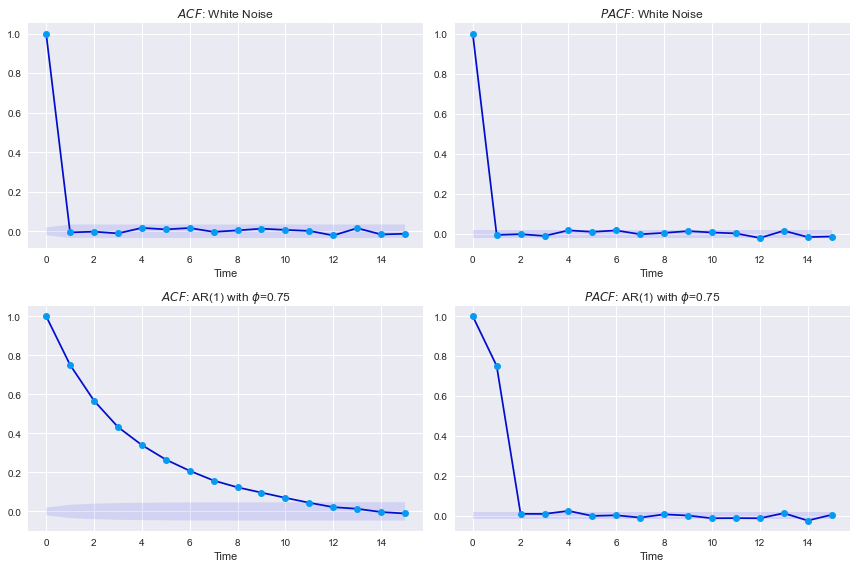

In [23]:
nlags = 15
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

my_plot_acf(y_wn_long, nlags , ax=axes[0,0], title_string="White Noise")
my_plot_pacf(y_wn_long, nlags , ax=axes[0,1], title_string="White Noise")

my_plot_acf(y_ar1_model1_long, nlags, ax=axes[1,0], title_string="AR(1) with $\\phi$=" + str(phi1_model1))
my_plot_pacf(y_ar1_model1_long, nlags , ax=axes[1,1], title_string="AR(1) with $\\phi$=" + str(phi1_model1))

fig.tight_layout()

#### Summary for ACF/PACF

The Table below (Table 3.1 p. 101 in Shumway and Stoffer, 2016) summarizes what we can conclude from ACFs/PACFs about the order of an ARMA($p$,$q$) process.

| Function | AR($p$)             | MA($q$)            | ARMA($p$,$q$) |
|:---      |    :---:            |:---:               |:---:          |
| ACF      | Tails off           | Cuts off for j > q | Tails off     |
| PACF     | Cuts off for j > p  | Tails off          | Tails off     |   

In practice, we have seen that it is sometimes tricky to distinguish close processes, especially in small samples. For those cases, using other and more formal criteria is then required. Some other like AIC/BIC, significance of lags, *etc.*.

### OLS Estimation, Diagnostics

**Kendall Bias**

Recall that the OLS estimate for AR(1) is biased downwards:
$$
    \mathbb{E}_t[\hat{\phi}] \approx \phi - \frac{1+3\phi}{T}
$$

The bias increases with $\phi$ in absolute value (i.e. the estimate is biased downwards even more), and decreases with the sample size $T$. It is therefore a good idea to correct the estimate, especially when it is large, and the sample size is small.

To do so, one often estimates the bias as $- \frac{1+3\hat{\phi}}{T}$ (i.e. by replacing the true value $\phi$ by its estimate $\hat{\phi}$, so that the bias-corrected estimate is:
$$
    \hat{\phi} + \frac{1+3\hat{\phi}}{T}
$$

#### AIC, BIC for model selection

In [24]:
y_arma2_long = simulate_arma(ar=[0.3], nsample=1000).squeeze()

In [25]:
res = sm.tsa.arma_order_select_ic(y_arma2_long, ic=["aic", "bic"], trend="nc")
res

D:\anaconda3\envs\mfestats\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda3\envs\mfestats\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_mode

{'aic':              0            1            2
 0          NaN  2813.463253  2804.402162
 1  2804.389289  2806.152954  2804.899264
 2  2806.095077  2805.083841  2805.771157
 3  2806.825597  2806.013193  2806.740345
 4  2807.104114  2807.565825  2806.545067,
 'bic':              0            1            2
 0          NaN  2823.278764  2819.125428
 1  2814.204799  2820.876220  2824.530285
 2  2820.818343  2824.714862  2830.309933
 3  2826.456618  2830.551969  2836.186877
 4  2831.642891  2837.012357  2840.899354,
 'aic_min_order': (1, 0),
 'bic_min_order': (1, 0)}

#### Esimation by statsmodels

In [26]:
model = sm.tsa.arima.ARIMA(y_arma2_long, order=(1, 0, 0))
res = model.fit(cov_type='robust')

In [27]:
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1399.340
Date:                Mon, 02 Aug 2021   AIC                           2804.680
Time:                        22:52:02   BIC                           2819.404
Sample:                             0   HQIC                          2810.276
                               - 1000                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0560      0.043      1.309      0.191      -0.028       0.140
ar.L1          0.2755      0.031      8.913      0.000       0.215       0.336
sigma2         0.9615      0.045     21.138      0.0

#### Impulse response function

Text(0.5, 1.0, 'Impulse Response Functions')

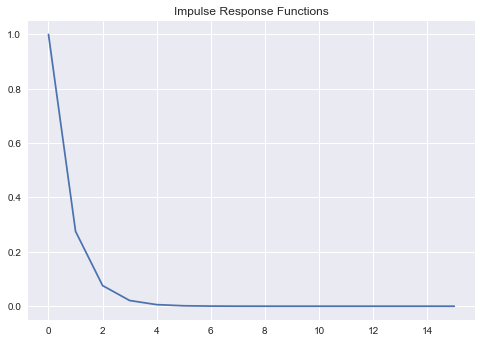

In [28]:
fig, ax = plt.subplots()
ax.plot(res.impulse_responses(steps=nlags))
ax.set_title('Impulse Response Functions')

### ADF test

In [29]:
from statsmodels.tsa.adfvalues import mackinnonp, mackinnoncrit

def nth_moment(y, counts, center, n):
    """ Calculates nth moment around 'center"""
    return np.sum((y - center)**n) / np.sum(counts)

def calc_ols(y, x, addcon=True):
    """Calculate OLS coefficients, SEs, and other statistics from scratch"""
    Nobs = y.shape[0]
    if addcon:
        X = np.c_[np.ones((Nobs, 1)), x] # append the [Nobs x 1] columns of ones.
    else:
        X = x    
    k = X.shape[1]    
    XX = np.dot(X.T, X) # Construct sample average of E[X'X]
    Xy = np.dot(X.T, y) # Construct sample average of E[X'Y]
    XX_inv = np.linalg.inv(XX)
    
    ### OLS estimator: algebraic solution for OLS. beta_hat = (E[X'X]^-1)*(E[X'Y])
    beta_hat = np.linalg.solve(XX, Xy) 

    ### R-squared (can use np.dot or @ for "dot product")
    y_hat = np.dot(X, beta_hat)
    resids = y - y_hat
    sse = np.dot(resids.T, resids)
    
    sst = (y - np.mean(y)).T@(y - np.mean(y))
    r_squared = 1 - (sse/sst) 

    ### Adjusted R-squared
    r_squared_adj = r_squared - (1 - r_squared)*((k - 1)/(Nobs - k))
    
    ### Variance-Covariance matrix: non-robust homoskedastic SEs
    sigma2_hat = sse / (Nobs - k)
    sigma2_mle = sse / (Nobs - 1)
    cov_matrix = np.dot(XX_inv, sigma2_hat)
    se = cov_matrix.diagonal()**0.5
    t_stat = beta_hat / se


    ### Variance-Covariance matrix: White (robust) heteroskedastic SEs:
    cov_matrix_robust = np.dot(np.dot(np.dot(np.dot(XX_inv, X.T), np.diag(resids**2)),X),XX_inv)
    cov_matrix_robust_unbiased = cov_matrix_robust 
    se_robust = cov_matrix_robust_unbiased.diagonal()**0.5
    t_stat_robust = beta_hat / se_robust
    
    ### log-likelihood (assumption of normality:
    loglikelihood = - (Nobs/2)*np.log(2*np.math.pi) - \
                      (Nobs/2)*np.log(sigma2_mle) - \
                      (1/(2*sigma2_mle))*sum(resids**2)
   
    ### Information criteria:
    hannan_quinn = ((-2*loglikelihood)/Nobs) + ((2*(k - 1)*np.log(np.log(Nobs)))/Nobs)
    aic = Nobs *(np.log(2*np.pi) + 1 + np.log((sum(resids**2)/(Nobs)))) + (((k - 1) + 1)*2)
    bic = -2*loglikelihood + np.log(Nobs)*((k - 1) + 1)
    
    ### Higher-order moments of the residuals:
    m1 = nth_moment(resids, resids.shape[0], center=0,  n=1)
    m2 = nth_moment(resids, resids.shape[0], center=m1, n=2)
    m3 = nth_moment(resids, resids.shape[0], center=m1, n=3)
    m4 = nth_moment(resids, resids.shape[0], center=m1, n=4)   
    skew = m3 / (m2**(3/2))
    kurtosis = m4 / (m2**2)
    
    ols_results = {'beta_hat': beta_hat,
                   'standard-errors': se, 
                   't-stat': t_stat, 
                   'standard-errors (robust)': se_robust, 
                   't-stat (robust)': t_stat_robust}                   

    stats = {"No. Observations": Nobs,
             "Df Residuals": Nobs - k,
             "Skewness of residuals:": skew,
             "Kurtosis of residuals:": kurtosis,
             "$R^2$":  r_squared,
             "adjusted-$R^2$": r_squared_adj,
             "Log-likelihood": loglikelihood,
             "Hannan-Quinn": hannan_quinn,
             "AIC": aic, 
             "BIC": bic}
    
    return ols_results, stats

def adf_test(y, nlags):
    """ ADF test for time series stationarity.
    
    Augmented Dickey-Fuller test with p-values obtained through 
    regression surface approximation from MacKinnon [1994], similar to 
    the statsmodels routine: statsmodels.tsa.stattools.adfuller
    
    Args:
        y: np.array, time series.
        nlags: int, number of lags in ADF test.
    
    """
    diff_z = np.diff(y, axis=0)
    z = y[:-1]  
    ols_results, _ = calc_ols(diff_z, z)
    df_stat = ols_results['t-stat'][1]
    p_value = mackinnonp(df_stat, regression='c', N=1)
    cr_val = mackinnoncrit(N=1, regression='c', nobs=len(y))
    print('(A)DF critical values |  1%: {:.3f},  5%:{:.3f},  10%:{:.3f}'.format(cr_val[0], cr_val[1], cr_val[2]))
    print('df test, (no lags)    |  df-stat: {:.3f},  p-value: {:.3f}'.format(df_stat, p_value))
    
    for i in range(1, nlags + 1):       
        z = np.column_stack((z[1:], diff_z[:-i]))
        ols_results, _ = calc_ols(diff_z[i:], z)
        adf_stat = ols_results['t-stat'][1]
        p_value = mackinnonp(adf_stat, regression='c', N=1)
        print('ADF test, lag# = '+ str(i),'   | ADF-stat: {:.3f},  p-value: {:.3f}'.format(adf_stat, p_value))

In [30]:
# random walk
random_walk = simulate_arma(ar=[1], nsample=1000).squeeze()
adf_test(random_walk, nlags=1)

(A)DF critical values |  1%: -3.437,  5%:-2.864,  10%:-2.568
df test, (no lags)    |  df-stat: -1.714,  p-value: 0.424
ADF test, lag# = 1    | ADF-stat: -1.732,  p-value: 0.415


The null hypothesis for ADF test is the process has a unit root. From the test result it can be seen that we cannot reject the null, and indeed the time series is nonstationary (random walk).

### VAR

VAR($p$) model that generalizes the AR($p$) model:
$$
\mathbf{Y}_t = c + \sum_{j=1}^p \mathbf{A}_j \mathbf{Y}_{t-j} + \mathbf{e}_t
$$

where $\mathbf{Y}_t$ is a $K \times 1$ vector and each $\mathbf{A}_j$ is a $K \times K$ matrix of coefficients.

In [31]:
df = pd.read_csv('../data/ftse2011.dat', delim_whitespace=True)
df.rename(columns={'Data': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

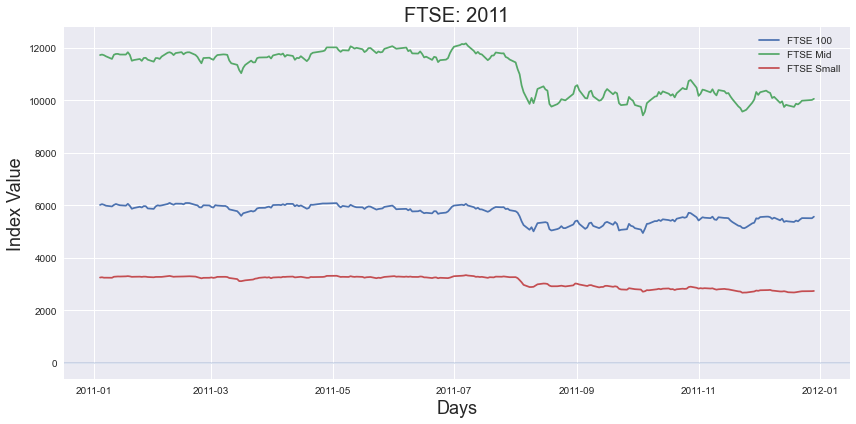

In [32]:
### Plot the raw data
fig, axes = plt.subplots(figsize=(12,6))
axes.plot(df[['FTSE100', 'FTSE Mid', 'FTSE Small']])

axes.set_xlabel('Days', fontsize=18)
axes.set_ylabel('Index Value', fontsize=18)
axes.set_title('FTSE: ' + str(df.index.year.min()), fontsize=20)
axes.axhline(y=0, linewidth=0.4)
axes.legend(['FTSE 100', 'FTSE Mid', 'FTSE Small'])
fig.tight_layout()

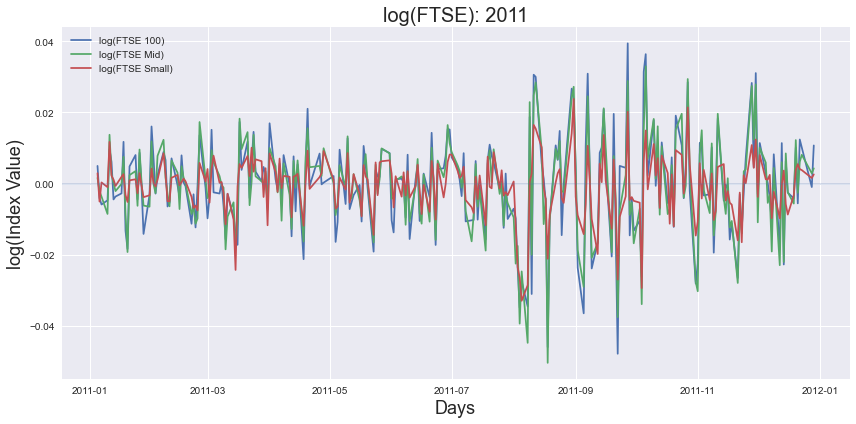

In [33]:
dflog = np.log(df).diff().dropna()

### Plot the log data
fig, axes = plt.subplots(figsize=(12,6))
axes.plot(dflog[['FTSE100', 'FTSE Mid', 'FTSE Small']])

axes.set_xlabel('Days', fontsize=18)
axes.set_ylabel('log(Index Value)', fontsize=18)
axes.set_title('log(FTSE): ' + str(dflog.index.year.min()), fontsize=20)
axes.axhline(y=0, linewidth=0.4)
axes.legend(['log(FTSE 100)', 'log(FTSE Mid)', 'log(FTSE Small)'])
fig.tight_layout()

In [34]:
# VAR model by statsmodels
var_model = sm.tsa.VAR(dflog)
var_est = var_model.fit(maxlags=1)
var_est.summary()

D:\anaconda3\envs\mfestats\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 02, Aug, 2021
Time:                     22:53:30
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -30.4129
Nobs:                     248.000    HQIC:                  -30.5145
Log likelihood:           2748.59    FPE:                5.22404e-14
AIC:                     -30.5829    Det(Omega_mle):     4.97920e-14
--------------------------------------------------------------------
Results for equation FTSE100
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.000332         0.000850           -0.391           0.696
L1.FTSE100            0.462384         0.182258            2.537           0.011
L1.FTSE Mid          -0.527746         0.215400           

**We could estimate each equation in our system equation-by-equation via OLS. We will get the same thing as above.**

In [35]:
### Fit each equation by OLS
Y = dflog.values[1:,:]
y_lags = dflog.shift(1).values[1:,:]
y_lags = sm.add_constant(y_lags)

for k in range(3):
    ols_fit = sm.OLS(Y[:,k], y_lags).fit()
    print(dflog.columns[k])
    print(ols_fit.summary(), '\n')

FTSE100
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     3.058
Date:                Mon, 02 Aug 2021   Prob (F-statistic):             0.0290
Time:                        22:55:38   Log-Likelihood:                 721.60
No. Observations:                 248   AIC:                            -1435.
Df Residuals:                     244   BIC:                            -1421.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.391 

#### Granger causality tests

In [36]:
### Granger causality tests for chosen p_lag
# http://www.statsmodels.org/devel/vector_ar.html#granger-causality
p_lag = 1
var_est = var_model.fit(maxlags=p_lag)
print(var_est.test_causality('FTSE100', ['FTSE Mid', 'FTSE Small']).summary(), '\n')
print(var_est.test_causality('FTSE Mid', ['FTSE100', 'FTSE Small']).summary(), '\n')
print(var_est.test_causality('FTSE Small', ['FTSE Mid', 'FTSE100']).summary())

Granger causality F-test. H_0: ['FTSE Mid', 'FTSE Small'] do not Granger-cause FTSE100. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         3.007          3.008   0.050 (2, 732)
---------------------------------------------- 

Granger causality F-test. H_0: ['FTSE100', 'FTSE Small'] do not Granger-cause FTSE Mid. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         7.725          3.008   0.000 (2, 732)
---------------------------------------------- 

Granger causality F-test. H_0: ['FTSE Mid', 'FTSE100'] do not Granger-cause FTSE Small. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         4.593          3.008   0.010 (2, 732)
----------------------------------------------
